<a href="https://colab.research.google.com/gist/jdrapala/dcf5cfecc2bb7682d9af570d6b774356/sadism_4_numerical_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Numerical optimization**

**Analytical methods** - an <font color='blue'> explicit formula </font> is given, and  the solution is <font color='blue'> exact </font>.
<br>
**Numerical methods** - <font color='blue'> iterative </font> trial-and-error   routine,  the solution is <font color='blue'> approximated </font>.

The notebook is composed of two sections: <br>
I.	Introduction to library solvers, <br>
II.	Visual reports of the search process.
Part I gives instructions on <font color='orange'>**how to use solvers**</font>. <br>
Part II explains the <font color='orange'>**mechanism under the hood**</font>, which allows more efficient use of solvers in your projects.

### **Section I** - <font color='orange'>How to use solvers.

In [1044]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#### **Unconstrained optimization**

Let us begin with a single-dimensional objective function:
$$F(x) = \cos x - 3\exp\left[-(x-0.2)^2\right]$$

In [1045]:
def F(x):
    return np.cos(x) - 3 * np.exp(-(x - 0.2) ** 2)


x_init = np.random.uniform(-1, 4)
optimize.fmin(F, x_init)  # call for the Nelder-Mead algorithm


Optimization terminated successfully.
         Current function value: -2.023866
         Iterations: 17
         Function evaluations: 34


array([0.23958775])

What about the maximum?
$$ \arg\max F(x) = \arg\min-F(x)$$

In [1046]:
def neg_F(x):
    return -F(x)


optimize.fmin(neg_F, np.random.uniform(-1, 4))

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 18
         Function evaluations: 36


array([6.28316723])

Things are similar when it comes to multidimensional decision vector $\mathbf{x} \in \Re^N$ .
Here, you have an objective function where the minimum point is easy to guess:
$$F(x)=(x_1−2)^2+(x_2+1)^2, \quad \text{ where } \mathbf{x} = \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right].$$

In [1047]:
def F(x):
    return (x[0] - 2) ** 2 + (x[1] + 1) ** 2


F([3, -0.5])
x = np.random.randint(-100, 101, 2)
optimize.fmin(F, x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 103


array([ 1.99997495, -1.00002663])

This is the risky way of plugging the vector $x$ in, because $x_i$ corresponds to `x[i-1]` which may confuse you easily.

This way is better:

In [1048]:
def F(x):
    x1, x2 = x  # the so called tuple unpacking
    return (x1 - 2) ** 2 + (x2 + 1) ** 2

Notice that this time the initial point has to be multidimensional.

In [1049]:
x_init = np.random.normal(loc=0, scale=0.1, size=2)
x_best = optimize.fmin(F, x_init, disp=False)  # the solver does not return the report message
print(f'The optimum is {x_best}\nThe value of the objective function at this point is {F(x_best):f}')

The optimum is [ 2.00002814 -0.99995751]
The value of the objective function at this point is 0.000000


Try out the more advanced (mathematically) methods, e.g.: 
* [`fmin_powell`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_powell.html),
* [`fmin_cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html),
* [`fmin_bfgs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html).

Although these methods are loaded with more advanced mathematical concepts, you can use them in the same way as `fmin`.

In [1050]:
def F(x):
    x1, x2 = x  # the so called tuple unpacking
    return (x1 - 2) ** 2 + (x2 + 1) ** 2


x_init = np.random.randint(-10, 11, 2)
print(optimize.fmin_powell(F, x))
print(optimize.fmin_cg(F, x))
print(optimize.fmin_bfgs(F, x))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 34
[ 2. -1.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 39
         Gradient evaluations: 13
[ 2.00000001 -1.00000001]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
[ 2.00000345 -1.00000287]


The procedure [`minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) is a wrapper for single-dimensional solvers. Returns a dictionary containing the most important information about the search process. The the solution is kept in `.x`.

In [1051]:
optimize.minimize(F, x0=x_init, method='Powell')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.262177448353619e-29
       x: [ 2.000e+00 -1.000e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 34

In [1052]:
optimize.minimize(F, x0=x_init, method='Nelder-Mead').x  # equivalent to optimize.fmin(...)

array([ 2.00000599, -1.00001924])

When all other methods fail, the last resort is the *grid search* method. <br> You have to define a $N$-dimensional grid in a solution space, and every knot on this grid will be given the value of the objective function.

In [1053]:
print(optimize.brute(F, (slice(120, 180, 1), slice(110, 160, 1))))  # ?????????

[ 2.00002524 -1.00002032]


### **Constrained optimization**


The easiest ones to deal with are constraints defined as simple **bounds** that cut an $N$-dimensional cube from the solution space.

Objective function: 
$$F(\mathbf{x}) = (x_1-1)^2 + (x_2+2)^2 + x_1x_2$$
Constraints: 
$$3.5 \leq x_1 \leq 6$$
$$-5 \leq x_2 \leq -2$$

In [1054]:
def F(x):
    x1, x2 = x
    return (x1 - 1) ** 2 + (x2 + 2) ** 2 + x1 * x2


constraints = {'x1': (3.5, 6),
               'x2': (-5, -2)}

x_init = (np.random.uniform(*constraints['x1']),
          np.random.uniform(*constraints['x2']))
optimize.minimize(F, x_init, method='TNC', bounds=list(constraints.values()))

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -3.812499999854401
       x: [ 3.500e+00 -3.750e+00]
     nit: 4
     jac: [ 1.250e+00 -2.416e-05]
    nfev: 81

**Constraints as functions** $g$ <br>

Take the same objective function but swap the constraint to:<br>
$g(\mathbf{x}) = x_2 + 2 + 2(x_1-3)^2 - (x_1 - 3)^4 \geq 0$. <br>
Notice that the convention of solver follows the $g(x) \geq 0$ convention (opposite to the lecture).

In [1055]:
def g(x):
    x1, x2 = x
    return x2 + 2 + 2 * (x1 - 3) ** 2 - (x1 - 3) ** 4


constraints = {'type': 'ineq', 'fun': g}

x_init = np.random.uniform(-5, 5, size=2)
optimize.minimize(F, x_init, method='SLSQP', constraints=constraints)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.316565307196722
       x: [ 3.762e+00 -2.824e+00]
     nit: 10
     jac: [ 2.700e+00  2.113e+00]
    nfev: 32
    njev: 10

Let us try another solver: [```fmin_cobyla```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cobyla.html).<br>
Objective function: 
$$F(\mathbf{x}) = x_1 x_2$$
Constraints: 
$$x_1^2 + x_2^2 \leq 1$$ 
$$x_2 \geq 0$$

In [1056]:
def F(x):
    x1, x2 = x
    return x1 * x2


def g1(x):
    x1, x2 = x
    return 1 - (x1 ** 2 + x2 ** 2)


def g2(x):
    x1, x2 = x
    return x2


x_init = np.random.uniform(0, 1, size=2)
x_best = optimize.fmin_cobyla(F, x_init, cons=[g1, g2])
#x_best = optimize.minimize(F, x_init, method='SLSQP',
#                           constraints=[{'type': 'ineq', 'fun': g1}, {'type': 'ineq', 'fun': g2}])
print(f'Minimum: {x_best}')
print(f'g1: {g1(x_best):f}')
print(f'g2: {g2(x_best):f}')

Minimum: [-0.70720526  0.7070083 ]
g1: -0.000000
g2: 0.707008


**Equality constraints**: $\quad g(\mathbf{x})=0$ <br>
Objective function: 
$$F(\mathbf{x}) = x_1^2 + x_2^2 + x_3^2$$ 
Constraints: 
$$x_1 = x_3$$
$$x_3 = x_1 + x_2 - 5$$

In [1057]:
def F(x):
    x1, x2, x3 = x
    return x1 ** 2 + x2 ** 2 + x3 ** 2


def g1(x):
    x1, x2, x3 = x
    return x1 - x3


def g2(x):
    x1, x2, x3 = x
    return x1 + x2 - 5 - x3


constraints = ({'type': 'eq', 'fun': g1},
               {'type': 'eq', 'fun': g2})

x_init = np.random.uniform(0, 1, size=3)
optimize.minimize(F, x_init, method='SLSQP', constraints=constraints)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 25.0
       x: [-2.852e-08  5.000e+00 -2.852e-08]
     nit: 5
     jac: [ 0.000e+00  1.000e+01  0.000e+00]
    nfev: 21
    njev: 5

**Linear optimization tasks** deserve dedicated solvers, such as:
* [```linprog```](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linprog.html),
* [cvxopt](https://cvxopt.org/) (external library),
* [PuLP](https://coin-or.github.io/pulp/main/installing_pulp_at_home.html)

Check also [scipy.optimize](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) and internet book [Scipy Lecture Notes](https://scipy-lectures.org/).

**Something more** than just a suggestion: <br>
Now you have the skills necessary to handle optimization tasks that were posed during classes but could not be approached with analytical methods.

*You work at a toy factory that produces two types of toys: teddy bears and toy cars. Each teddy bear requires 2 units of fabric and 1 unit of stuffing, while each toy car requires 1 unit of fabric and 2 units of stuffing. The factory has 40 units of fabric and 30 units of stuffing available. Teddy bears sell for $10 each, and toy cars sell for $15 each. The factory wants to maximize its profit while staying within the available resources.*

In [1058]:
from scipy.optimize import linprog

c = [-10, -15]

A = [[2, 1],
     [1, 2]]
b = [40, 30]

x_bounds = (0, None)
y_bounds = (0, None)

result = linprog(c, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds], method="highs")

x_optimal = result.x[0]
y_optimal = result.x[1]

optimal_profit = -result.fun

print("Optimal Solution:")
print("Number of teddy bears to produce:", x_optimal)
print("Number of toy cars to produce:", y_optimal)
print("Maximum Profit: $", optimal_profit)


Optimal Solution:
Number of teddy bears to produce: 16.666666666666664
Number of toy cars to produce: 6.666666666666667
Maximum Profit: $ 266.66666666666663


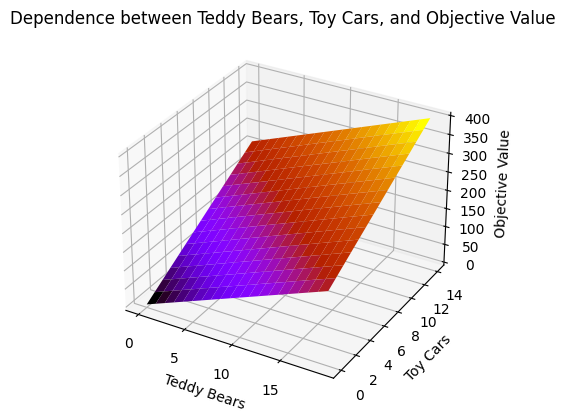

In [1059]:
import numpy as np
import matplotlib.pyplot as plt

teddy_bears = np.arange(0, 20)
toy_cars = np.arange(0, 15)
x1, x2 = np.meshgrid(teddy_bears, toy_cars)

Z = (10 * x1 + 15 * x2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, Z, cmap='gnuplot')

ax.set_xlabel('Teddy Bears')
ax.set_ylabel('Toy Cars')
ax.set_zlabel('Objective Value')
ax.set_title('Dependence between Teddy Bears, Toy Cars, and Objective Value')

plt.show()


In [1060]:
def vis_3D(F, ranges):
    x1_range = np.linspace(ranges[0], ranges[1], 50)
    x2_range = np.linspace(ranges[2], ranges[3], 50)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': '3d'})
    ax.plot_surface(X1_grid, X2_grid, F([X1_grid, X2_grid]), cmap='gnuplot')
    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_zlabel('$F$', fontsize=14)
    plt.show()


def vis_2D(F, x_history, ranges):
    x_init, x_best = x_history[0], x_history[-1]
    x1_range = np.linspace(ranges[0], ranges[1], num=100)
    x2_range = np.linspace(ranges[2], ranges[3], num=100)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
    Z_matrix = F([X1_grid, X2_grid])

    fig, ax = plt.subplots(figsize=(8, 8))
    cplot = ax.contourf(X1_grid, X2_grid, Z_matrix, 10, cmap='Spectral_r', alpha=1)
    clines = ax.contour(X1_grid, X2_grid, Z_matrix, 10, colors='black')
    for p in x_history:
        ax.plot(p[0], p[1], 'o',
                color='white', markeredgecolor='black', markersize=5, alpha=0.7)
    ax.plot(x_init[0], x_init[1], 'd',
            color='gray', markeredgecolor='black', markersize=10, alpha=0.7)
    ax.plot(x_best[0], x_best[1], 'h',
            color='white', markeredgecolor='black', markersize=15)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)
    ax.clabel(clines)
    fig.colorbar(cplot)
    return fig, ax

Text(0.5, 0.92, 'Dependence between Teddy Bears, Toy Cars, and Objective Value')

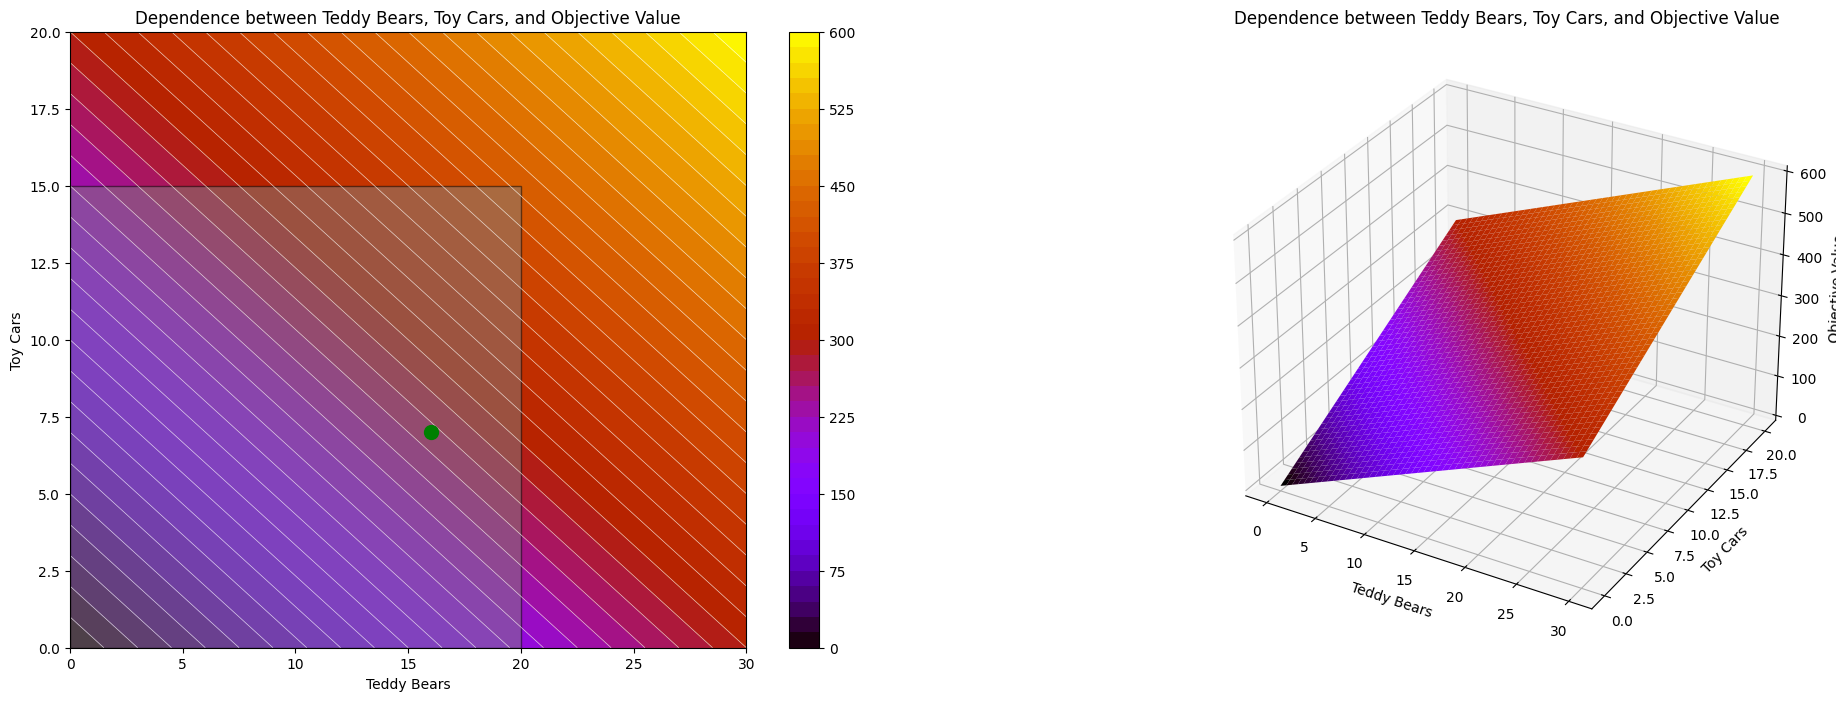

In [1061]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def F(x):
    x1, x2 = x
    return 10 * x1 + 15 * x2


teddy_bears = np.arange(0, 30)
toy_cars = np.arange(0, 20)
x1, x2 = np.meshgrid(teddy_bears, toy_cars)

resolution = 50
x1_range = np.linspace(start=0, stop=30, num=resolution)
x2_range = np.linspace(start=0, stop=20, num=resolution)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
Z_matrix = F((x1_grid, x2_grid))

fig = plt.figure(figsize=(24, 8))


ax = fig.add_subplot(121)

c1 = ax.contourf(x1_grid, x2_grid, Z_matrix, 50, cmap='gnuplot')
c2 = ax.contour(x1_grid, x2_grid, Z_matrix, 50, colors='white', linewidths=0.5, alpha=0.75)
ax.set_xlabel('Teddy Bears')
ax.set_ylabel('Toy Cars')
ax.set_title('Dependence between Teddy Bears, Toy Cars, and Objective Value')

ax.add_patch(patches.Rectangle((0, 0),20,15, facecolor='gray', edgecolor='black', alpha=0.5))
ax.plot(16,7,'o',color='green',markersize=10)

fig.colorbar(c1, ax=ax)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x1_grid, x2_grid, Z_matrix, cmap='gnuplot')

ax.set_xlabel('Teddy Bears')
ax.set_ylabel('Toy Cars')
ax.set_zlabel('Objective Value')
ax.set_title('Dependence between Teddy Bears, Toy Cars, and Objective Value')


In [1062]:
from pulp import LpProblem, LpVariable, LpMaximize

problem = LpProblem("ToyFactory", LpMaximize)

x = LpVariable("x", lowBound=0, cat="Integer")  # Number of teddy bears
y = LpVariable("y", lowBound=0, cat="Integer")  # Number of toy cars

profit = 10 * x + 15 * y
problem += profit

fabric_constraint = 2 * x + y <= 40
stuffing_constraint = x + 2 * y <= 30
problem += fabric_constraint
problem += stuffing_constraint

problem.solve()

x_optimal = x.value()
y_optimal = y.value()

optimal_profit = problem.objective.value()

print("Optimal Solution:")
print("Number of teddy bears to produce:", x_optimal)
print("Number of toy cars to produce:", y_optimal)
print("Maximum Profit: $", optimal_profit)


Optimal Solution:
Number of teddy bears to produce: 16.0
Number of toy cars to produce: 7.0
Maximum Profit: $ 265.0


---
### **Section II** - <font color='orange'> how it works.

This part is about visual presentation of intermediate steps taken by solvers when searching for the solution. This part is about a deeper understanding of some properties of optimization methods implemented by solvers. This additional knowledge may be used to improve your skills, but it is not necessary for the proper use of solvers for your applications. You may treat this part of the notebook as a sort of interactive multimedia presentation. Put the main focus on the meaning behind the visualizations, do not waste your time for codes put here.

$$F(x) = \cos x - 3\exp\left[-(x-0.2)^2\right]$$

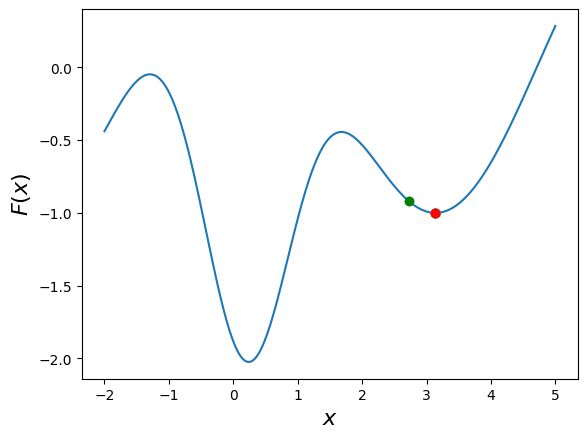

In [1063]:
def F(x):
    return np.cos(x) - 3 * np.exp(-(x - 0.2) ** 2)


x_init = np.random.uniform(-2, 4)
x_best, x_history = optimize.fmin(F, x_init, disp=False, retall=True)
# ------------------------------------------------------------------

x_history_array = np.array([x[0] for x in x_history])

x_range = np.linspace(-2, 5, 300)
plt.plot(x_range, F(x_range))
plt.plot(x_history_array, F(x_history_array), 'o', color='gray', alpha=0.7)
plt.plot(x_init, F(x_init), 'go')
plt.plot(x_best, F(x_best), 'ro')
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$F(x)$', fontsize=16)
plt.show()

Execute the code above a few times to see that the final solution depends on the choice of initial point.

The *analytical method* always returns the global optimum. <br>
With *numerical methods*, we never know whether the returned solution is globally or locally optimal.

**Think about it**: Is there a way to prevent a solver from getting caught in a local optimum?

* To address the issue of getting trapped in local optima we can use a metaheuristic algorithm, e.g. genetic algorithm or particle swarm.

* Metaheuristic algorithms, such as genetic algorithms or particle swarm optimization, are specifically designed to handle optimization problems with complex landscapes and multiple optima. These algorithms use stochastic search strategies and population-based approaches to explore the search space more thoroughly, potentially avoiding local optima.

* Unfortunalely,these techniques can improve the chances of finding the global optimum or escaping local optima, but they do not guarantee it

**Numerical study** <br>
Try to give a reasonable interpretation of the results (or simply tell the story that the images tell).

The gray dots represent the points visited during the optimization process. These points represent the values of x at each iteration of the optimization algorithm. The algorithm starts from an initial point denoted by the green dot (x_init), and it progresses towards the minimum.

The red dot represents the final result of the optimization, which is the value of x that corresponds to the minimum of the function F(x). This point is denoted by x_best.

$$F(\mathbf{x})=\sin x + \sin (3x-0.3)$$

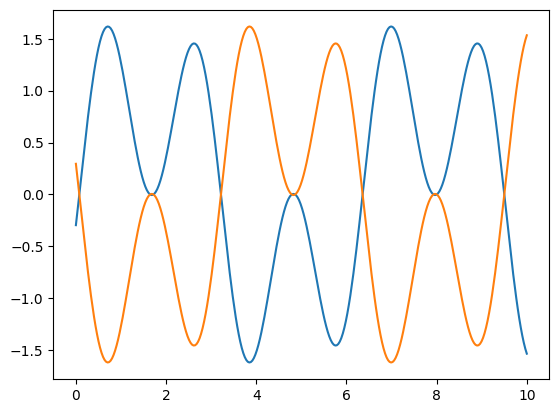

In [1064]:
def F(x):
    return np.sin(x) + np.sin(3 * x - 0.3)


def neg_F(x):
    return -F(x)


x_range = np.linspace(0, 10, 300)
plt.plot(x_range, F(x_range))
plt.plot(x_range, neg_F(x_range), color='tab:orange')
plt.show()

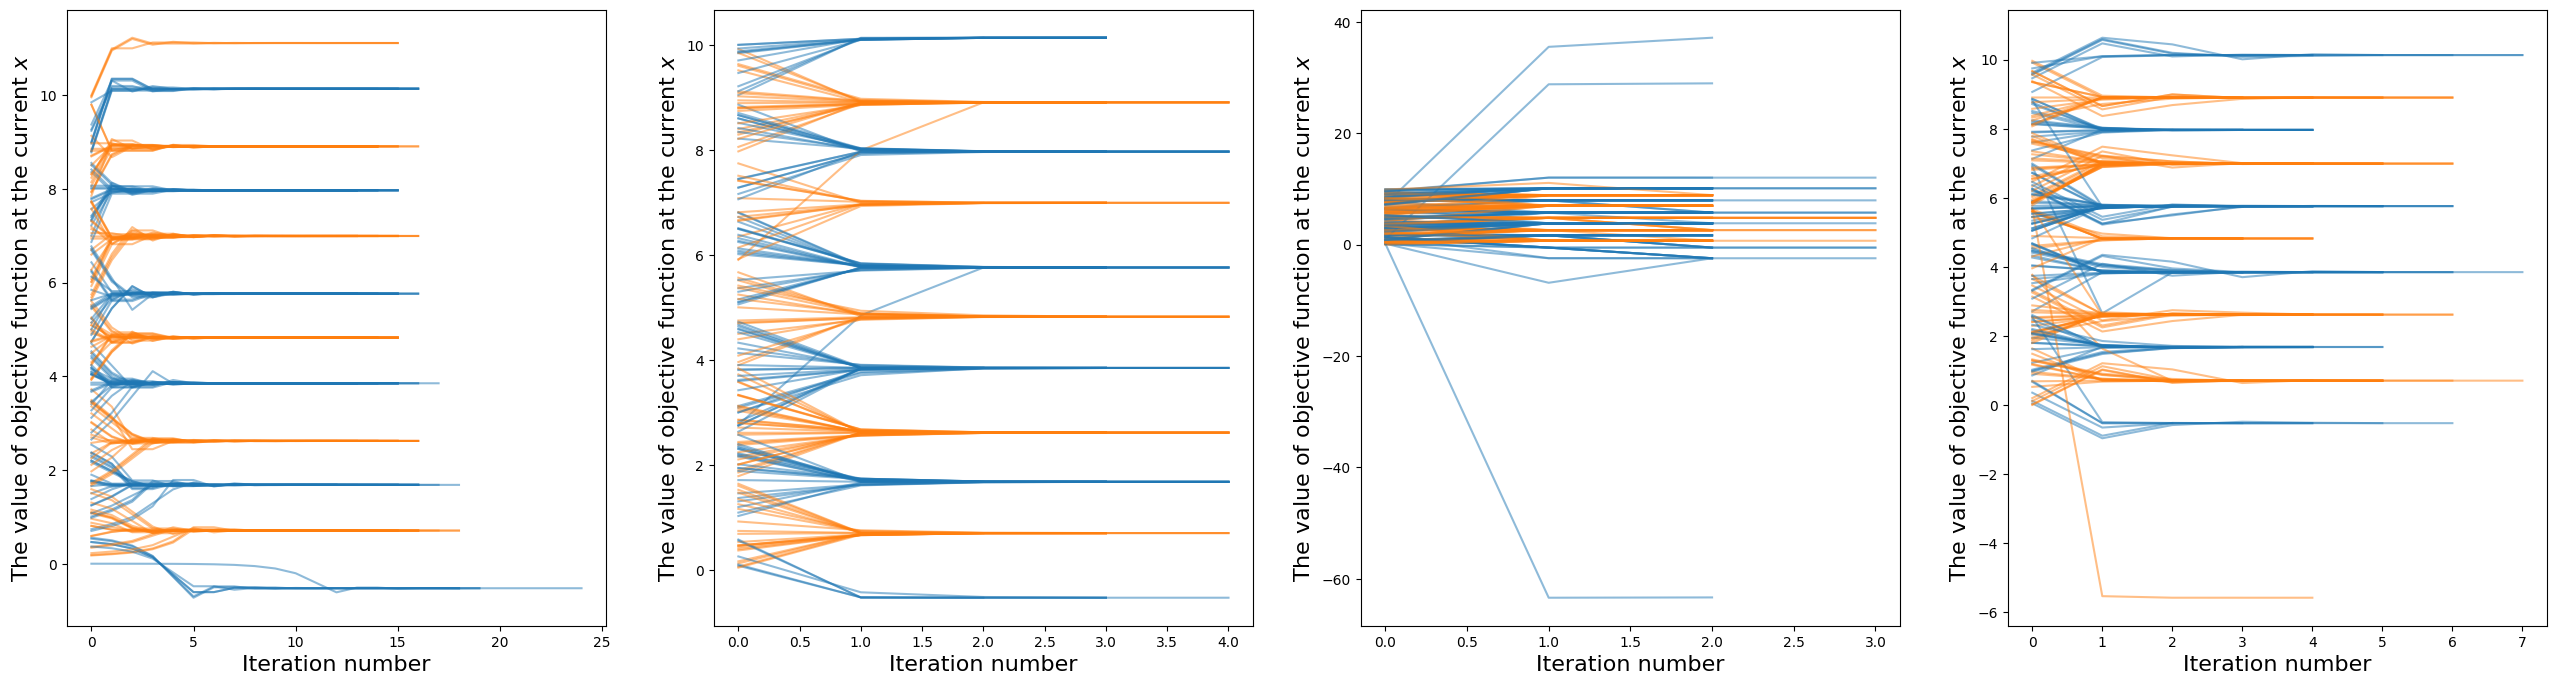

In [1065]:
fig, ax = plt.subplots(1, 4, figsize=(32, 8))

x_init = lambda: np.random.uniform(0, 10)

for _ in range(100):
    x_best, x_history = optimize.fmin(F, x_init(), disp=False, retall=True)
    ax[0].plot(x_history, color='tab:blue', alpha=0.5)
    x_best, x_history = optimize.fmin(neg_F, x_init(), disp=False, retall=True)
    ax[0].plot(x_history, color='tab:orange', alpha=0.5)

methods = ['CG', 'powell', 'BFGS']

for _ in range(100):
    sol = optimize.minimize(F, x_init(), method=methods[0], options={'disp': False, 'return_all': True})
    x_history = sol['allvecs']
    ax[1].plot(x_history, color='tab:blue', alpha=0.5)
    sol = optimize.minimize(neg_F, x_init(), method=methods[0], options={'disp': False, 'return_all': True})
    x_history = sol['allvecs']
    ax[1].plot(x_history, color='tab:orange', alpha=0.5)

    sol = optimize.minimize(F, x_init(), method=methods[1], options={'disp': False, 'return_all': True})
    x_history = sol['allvecs']
    ax[2].plot(x_history, color='tab:blue', alpha=0.5)
    sol = optimize.minimize(neg_F, x_init(), method=methods[1], options={'disp': False, 'return_all': True})
    x_history = sol['allvecs']
    ax[2].plot(x_history, color='tab:orange', alpha=0.5)

    sol = optimize.minimize(F, x_init(), method=methods[2], options={'disp': False, 'return_all': True})
    x_history = sol['allvecs']
    ax[3].plot(x_history, color='tab:blue', alpha=0.5)
    sol = optimize.minimize(neg_F, x_init(), method=methods[2], options={'disp': False, 'return_all': True})
    x_history = sol['allvecs']
    ax[3].plot(x_history, color='tab:orange', alpha=0.5)

for i in range(4):
    ax[i].set_xlabel('Iteration number', fontsize=16)
    ax[i].set_ylabel(r'The value of objective function at the current $x$', fontsize=16)

plt.show()

**Try different solvers** and observe how they affect the outcome of the above simulator.

To visualize results of two-dimensional search ($\mathbf{x}\in \Re^2$), you need to learn **to draw two-dimensional functions**.

In the following, we provide an example-based introduction.

In [1066]:
x1_range = np.arange(0, 5)
x2_range = np.arange(2, 6)
print(x1_range)
print(x2_range)

[0 1 2 3 4]
[2 3 4 5]


In [1067]:
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
print(X1_grid, end='\n\n')
print(X2_grid)

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]

[[2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]]


Using the examples above, could you figure out what the `meshgrid` procedure does?
* it creates a grid of coordinates - for each coordinate x1 we have corresponding x2 coordinate

In [1068]:
def F(x):
    x1, x2 = x
    return x1 + x2


Z_matrix = F([X1_grid, X2_grid])
print(Z_matrix)

[[2 3 4 5 6]
 [3 4 5 6 7]
 [4 5 6 7 8]
 [5 6 7 8 9]]


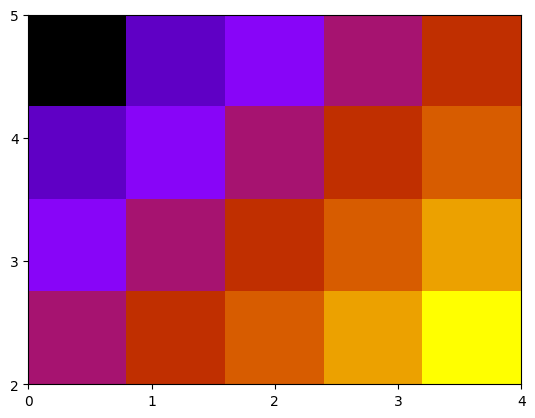

In [1069]:
plt.imshow(Z_matrix, extent=[x1_range.min(), x1_range.max(), x2_range.min(), x2_range.max()], cmap='gnuplot')
plt.xticks(x1_range)
plt.yticks(x2_range)
plt.show()

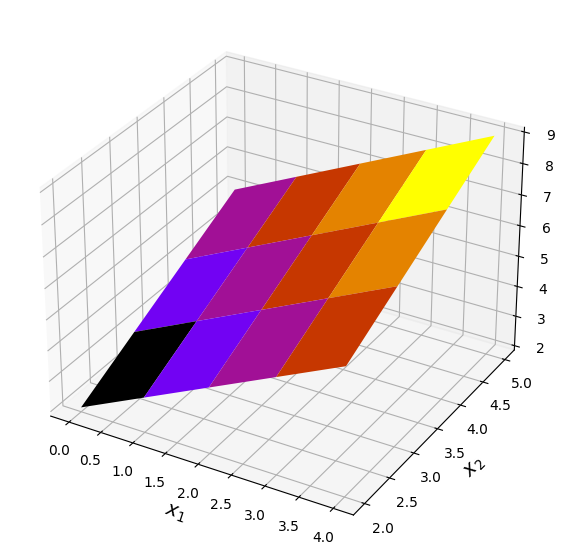

In [1070]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': '3d'})
ax.plot_surface(X1_grid, X2_grid, Z_matrix, cmap='gnuplot')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$F$', fontsize=14)
plt.show()

To improve the understanding of some numerical routines and machine learning methods, it is worth getting familiar with a multidimensional version of a quadratic function (obviously, here the number of dimensions is reduced to 2):
$$ \mathbf{x}^{\text{T}} A \mathbf{x},$$
Investigate the behavior of this function for different entries in matrix $\mathbf{A}$.

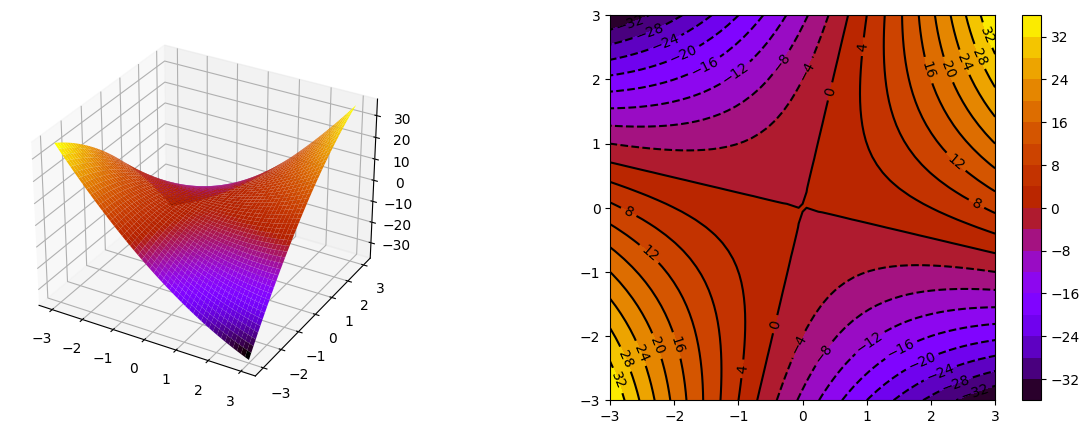

In [1071]:
def quadratic(x, A):
    x1, x2 = x
    a, b, c, d = A.flatten()
    return a * x1 ** 2 + d * x2 ** 2 + (b + c) * x1 * x2


# ================================
A = np.array([[1, 2],
              [2, -1]])
# ================================

resolution = 50
x1_range = np.linspace(start=-3, stop=3, num=resolution)
x2_range = np.linspace(start=-3, stop=3, num=resolution)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
Z_matrix = quadratic([X1_grid, X2_grid], A)

cmap = 'gnuplot'
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X1_grid, X2_grid, Z_matrix,
                rcount=resolution, ccount=resolution, cmap=cmap)

resolution_contour = 20
ax = fig.add_subplot(1, 2, 2)
c = ax.contourf(X1_grid, X2_grid, Z_matrix,
                resolution_contour, cmap=cmap)
c2 = ax.contour(X1_grid, X2_grid, Z_matrix,
                resolution_contour, colors='black')
ax.set_aspect('equal')
fig.colorbar(c, ax=ax)
plt.clabel(c2, inline=True, fontsize=10)
plt.show()

For convenience , below is a wrapper function that performs all the boring things necessary to make a 3D plot.

In [1072]:
def vis_3D(F, ranges):
    x1_range = np.linspace(ranges[0], ranges[1], 50)
    x2_range = np.linspace(ranges[2], ranges[3], 50)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': '3d'})
    ax.plot_surface(X1_grid, X2_grid, F([X1_grid, X2_grid]), cmap='gnuplot')
    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_zlabel('$F$', fontsize=14)
    plt.show()


And this is how to use it.

$$F(\mathbf{x})=3(x_1-2)^2 \cdot (x_2+1)^2$$

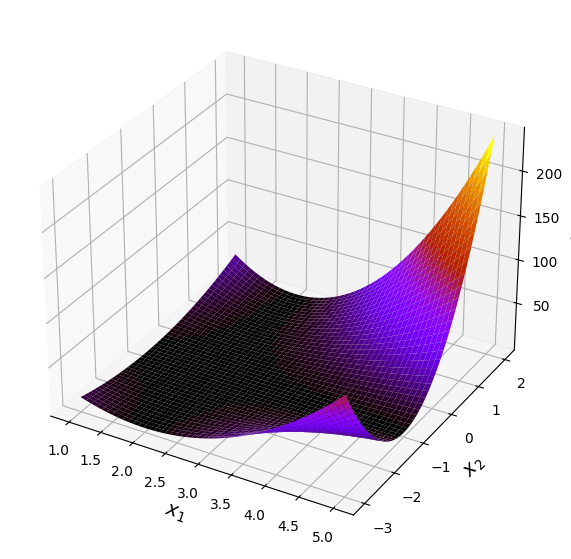

In [1073]:
def F(x):
    x1, x2 = x
    return 3 * (x1 - 2) ** 2 * (x2 + 1) ** 2


vis_3D(F, ranges=[1, 5, -3, 2])

And this is a plot that gives a contour version of the visualization and shows all intermediate points that were visited during the search process.

In [1074]:
def vis_2D(F, x_history, ranges):
    x_init, x_best = x_history[0], x_history[-1]
    x1_range = np.linspace(ranges[0], ranges[1], num=100)
    x2_range = np.linspace(ranges[2], ranges[3], num=100)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
    Z_matrix = F([X1_grid, X2_grid])

    fig, ax = plt.subplots(figsize=(8, 8))
    cplot = ax.contourf(X1_grid, X2_grid, Z_matrix, 10, cmap='Spectral_r', alpha=1)
    clines = ax.contour(X1_grid, X2_grid, Z_matrix, 10, colors='black')
    for p in x_history:
        ax.plot(p[0], p[1], 'o',
                color='white', markeredgecolor='black', markersize=5, alpha=0.7)
    ax.plot(x_init[0], x_init[1], 'd',
            color='gray', markeredgecolor='black', markersize=10, alpha=0.7)
    ax.plot(x_best[0], x_best[1], 'h',
            color='white', markeredgecolor='black', markersize=15)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)
    ax.clabel(clines)
    fig.colorbar(cplot)
    return fig, ax

This is how it works.

$$F(\mathbf{x}) = (x_1 - 1)^2 + (x_2 + 2)^2$$

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 63
         Function evaluations: 120


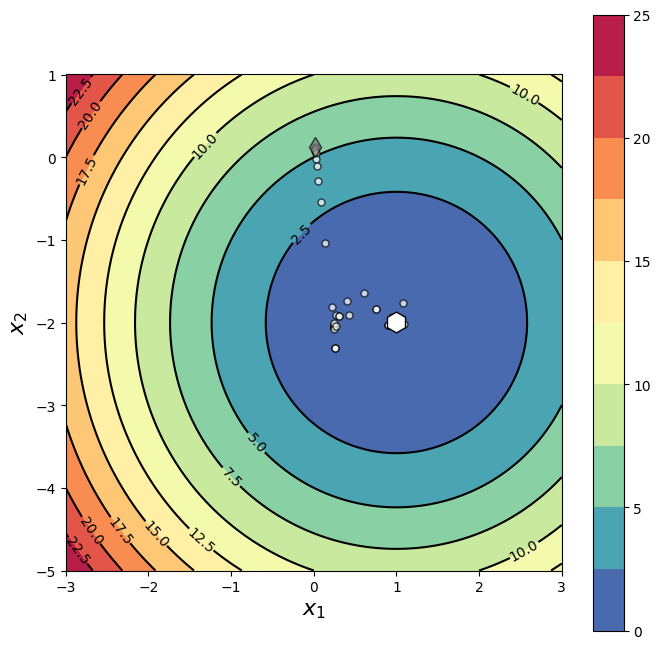

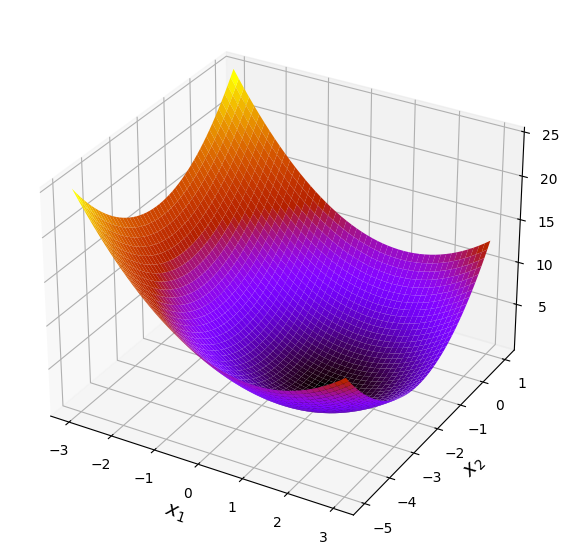

In [1075]:
def F(x):
    x1, x2 = x
    return (x1 - 1) ** 2 + (x2 + 2) ** 2


x_best, x_history = optimize.fmin(F,
                                  np.random.uniform(-1, 1, size=2),
                                  retall=True)

ranges = [-3, 3, -5, 1]
vis_2D(F, x_history, ranges)
vis_3D(F, ranges)

The Rosenbrock function:
$$F(\mathbf{x}) = (1-x_1)^2 + 100(x_2 - x_1^2)^2$$

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 89
         Function evaluations: 167


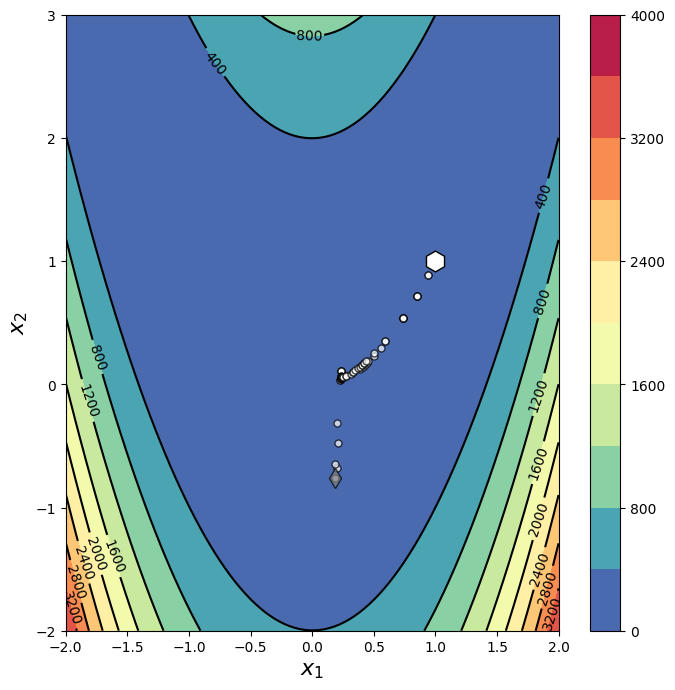

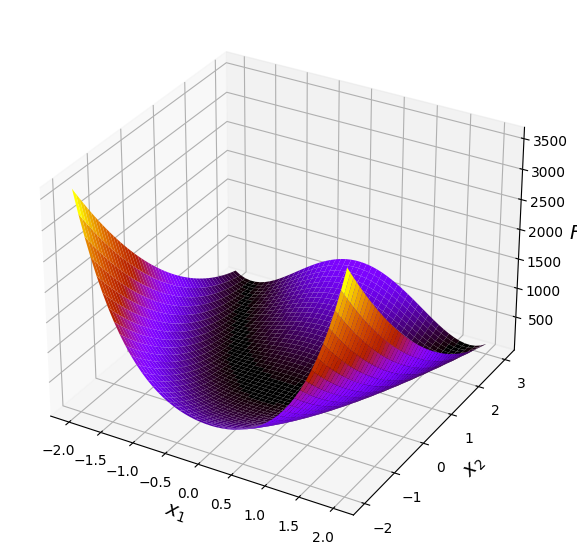

In [1076]:
def F(x):
    x1, x2 = x
    return (1 - x1) ** 2 + 100 * (x2 - x1 ** 2) ** 2


# both decision variables are drawn from different ranges
x_init = (np.random.uniform(-1, 2), np.random.uniform(-2, 1))
x_best, x_history = optimize.fmin(F, x_init, retall=True)

ranges = [-2, 2, -2, 3]
vis_2D(F, x_history, ranges)
vis_3D(F, ranges)

$$F(\mathbf{x}) = \left(\exp\left[-x_1-1\right]\right)^2 + (x_2+2)^2 - x_1x_2 + 10\left(\sin 4x_1 + \cos 5x_2\right)$$

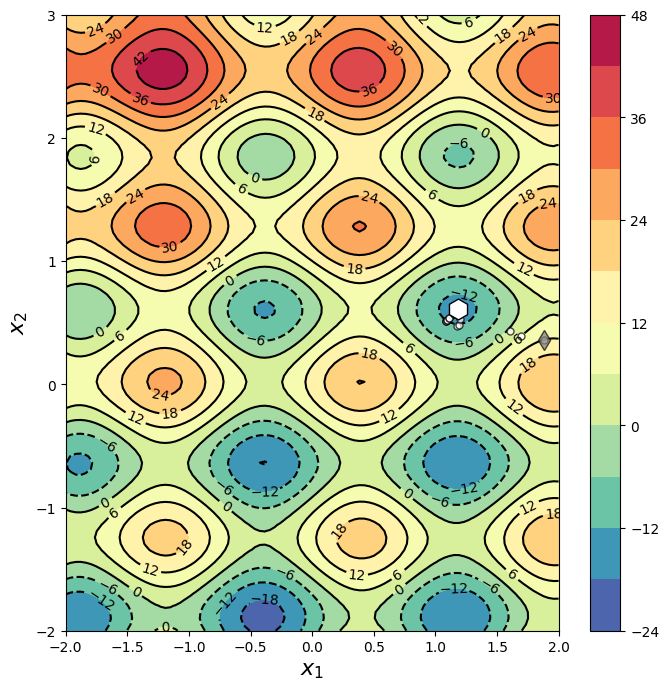

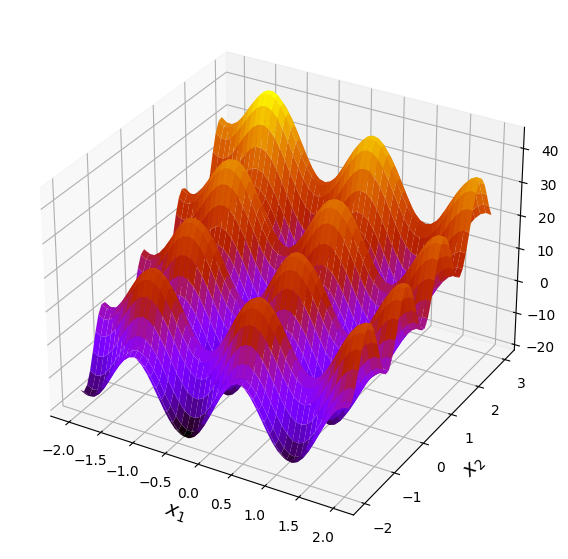

In [1077]:
def F(x):
    x1, x2 = x
    return np.exp(-x1 - 1) ** 2 + (x2 + 2) ** 2 - x1 * x2 + 10 * (np.sin(4 * x1) + np.cos(5 * x2))


x_init = (np.random.uniform(-2, 2), np.random.uniform(-2, 3))
x_opt, x_history = optimize.fmin(F, x_init, retall=True, disp=False)

ranges = [-2, 2, -2, 3]
vis_2D(F, x_history, ranges)
plt.show()
vis_3D(F, ranges)

**Homework**: Determine the minimum of the following function
$$F(\mathbf{x}) = \left(4\sin\pi x_1 + 6\sin\pi x_2\right) + (x_1-1)^2 + (x_2-1)^2$$
and visualize the solution.

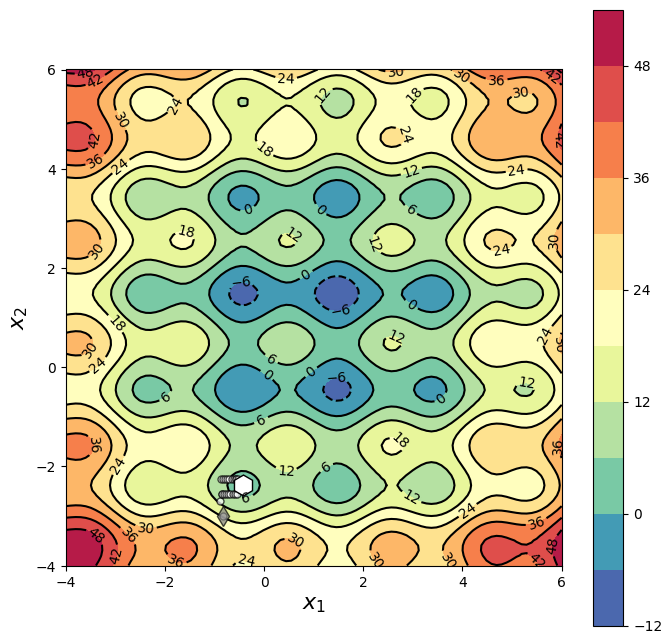

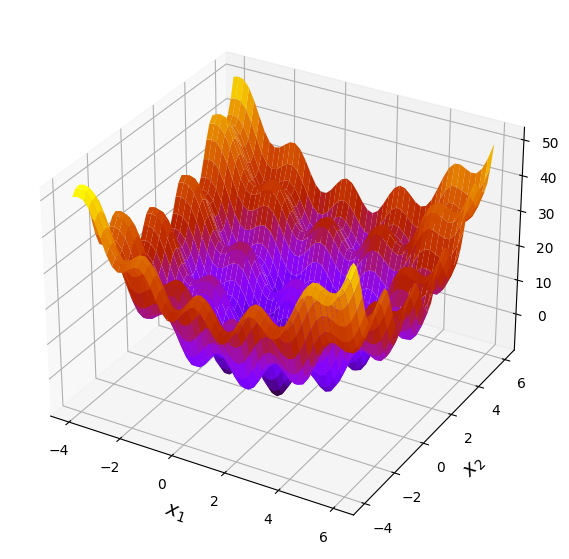

In [1078]:
def F(x):
    x1, x2 = x
    return 4 * np.sin(np.pi * x1) + 6 * np.sin(np.pi * x2) + (x1 - 1) ** 2 + (x2 - 1) ** 2


x_init = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))
x_best, x_history = optimize.fmin(F, x_init, retall=True, disp=False)

ranges = [-4, 6, -4, 6]
vis_2D(F, x_history, ranges)
vis_3D(F, ranges)


**Visualization of constraints**

In [1079]:
def vis_2D_constr(F, x_init, x_best, ranges, constraints, gx=None):
    fig, ax = vis_2D(F, x_history=[x_init, x_best], ranges=ranges)

    if 'fun' in constraints:
        x1_range = np.linspace(ranges[0], ranges[1], num=100)
        g_x1_curve = gx(x1_range)
        ax.plot(x1_range, g_x1_curve, color='black')
        ax.fill_between(x1_range, g_x1_curve, color='grey', alpha=0.7)
        ax.set_ylim(*ranges[2:])
    else:
        feasible_solutions = plt.Rectangle((constraints['x1'][0], constraints['x2'][0]),
                                           constraints['x1'][1] - constraints['x1'][0],
                                           constraints['x2'][1] - constraints['x2'][0],
                                           facecolor='gray', edgecolor='black', alpha=0.7)
        ax.add_patch(feasible_solutions)
    ax.plot(x_init[0], x_init[1], 'd',
            color='gray', markeredgecolor='black', markersize=10, alpha=0.7)
    return fig, ax

Objective function: 
$$F(\mathbf{x}) = (x_1-1)^2 + (x_2+2)^2 + x_1x_2$$
Constraints: 
$$3.5 \leq x_1 \leq 6$$
$$-5 \leq x_2 \leq -2$$

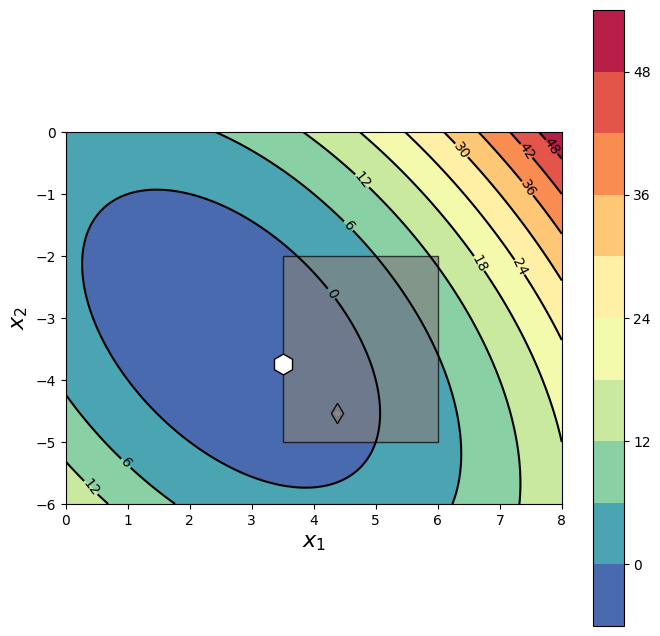

In [1080]:
def F(x):
    x1, x2 = x
    return (x1 - 1) ** 2 + (x2 + 2) ** 2 + x1 * x2


constraints = {'x1': (3.5, 6),
               'x2': (-5, -2)}

x_init = (np.random.uniform(*constraints['x1']),
          np.random.uniform(*constraints['x2']))
x_best = optimize.minimize(F, x_init, method='TNC', bounds=list(constraints.values())).x

ranges = [0, 8, -6, 0]
vis_2D_constr(F, x_init, x_best, ranges, constraints)
plt.show()

Objective function: 
$$F(\mathbf{x}) = (x_1-1)^2 + (x_2+2)^2 + x_1x_2$$
Constraints: 
$$g(\mathbf{x}) = x_2 + 2 + 2(x_1-3)^2 - (x_1 - 3)^4 \geq 0$$

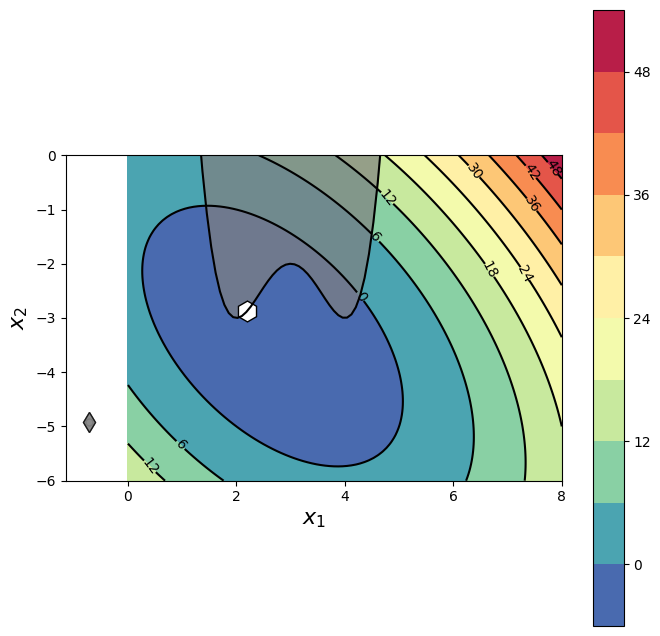

In [1081]:
def g(x):
    x1, x2 = x
    return x2 + 2 + 2 * (x1 - 3) ** 2 - (x1 - 3) ** 4


# to draw a curve g(x)=0 we have to define a separate function
# using the SymPy library you can automatize this task
gx = lambda x1: -2 - 2 * (x1 - 3) ** 2 + (x1 - 3) ** 4

constraints = {'type': 'ineq', 'fun': g}

x_init = np.random.uniform(-5, 5, size=2)
x_best = optimize.minimize(F, x_init, method='SLSQP', constraints=constraints).x

ranges = [0, 8, -6, 0]
vis_2D_constr(F, x_init, x_best, ranges, constraints, gx)
plt.show()